In [1]:
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from easydict import EasyDict as edict
from imutils.paths import list_images
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from monai.data import DataLoader
from monai.networks import nets
from monai import transforms
import torch.optim as optim
import torch.nn as nn
import seaborn as sns 
import numpy as np
import torch
import cv2
from utils.dataset_util import *

/opt/conda/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/ml/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-3])
DATA_PATH = f'{ROOT_PATH}/Dataset/brain_tumor'

args               = {}
args['lr']         = 1e-3
args['epochs']     = 20
args['device']     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args['batch_size'] = 32
args               = edict(args)

In [3]:
get_labels = lambda image_paths: [image_path.split(SEP)[-2] for image_path in image_paths]

train_paths  = sorted(list_images(f'{DATA_PATH}/Training'))
test_paths   = sorted(list_images(f'{DATA_PATH}/Testing'))

train_labels = get_labels(train_paths)
test_labels  = get_labels(test_paths)

lb2idx       = {lb  : idx for idx,  lb in enumerate(set(train_labels))}
idx2lb       = {idx :  lb for lb , idx in lb2idx.items()}

train_labels = [lb2idx[lb] for lb in train_labels]
test_labels  = [lb2idx[lb] for lb in  test_labels]

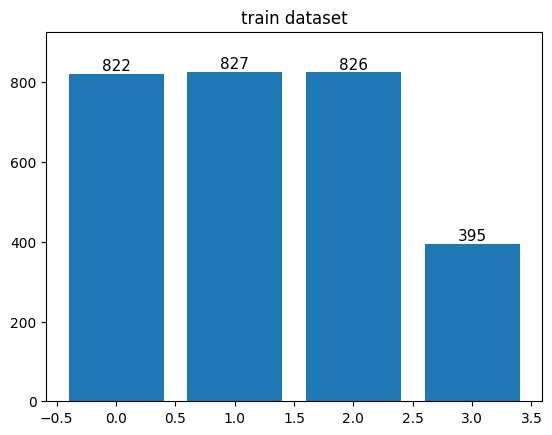

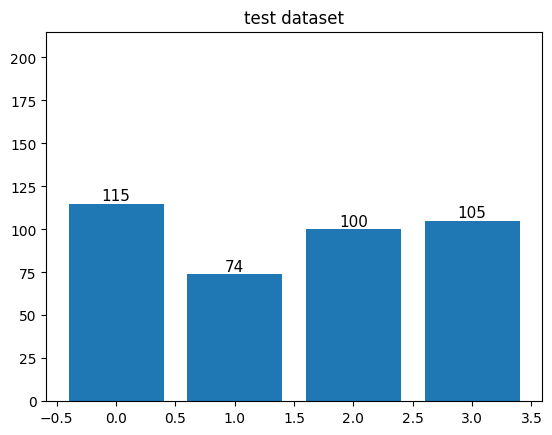

In [4]:
display_distribution(train_labels)
display_distribution(test_labels, dtype = 'test')

In [5]:
train_x, valid_x, train_y, valid_y = train_test_split(train_paths, train_labels, stratify = train_labels,
                                                      test_size = 0.2, shuffle = True)

In [6]:
class TumorDataset(Dataset):
    
    def __init__(self, images, labels, dtype = 'train'):
        
        self.images = images
        self.labels = labels
        self.dtype  = dtype
        
        self.transform = {}
        self.transform['train'] = transforms.Compose([
                                    transforms.Resize(spatial_size = (299, 299)),
                                    transforms.RandRotate(range_x = np.pi / 12, prob = 0.5, keep_size = True), 
                                    transforms.RandFlip(spatial_axis = 0, prob = 0.5)
                                ])
        
        self.transform['valid'] = transforms.Compose([
                                    transforms.Resize(spatial_size = (299, 299)),
                                ])
        
    def __len__(self):
        
        return len(self.images)
    
    
    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx], cv2.IMREAD_GRAYSCALE)
        image = np.expand_dims(image, axis = 0)
        image = self.transform[self.dtype](image)
    
        return image, self.labels[idx]

In [7]:
train_dataset = TumorDataset(train_x, train_y)
valid_dataset = TumorDataset(valid_x, valid_y, dtype = 'valid')

train_loader  = DataLoader(train_dataset, batch_size = args.batch_size, shuffle =  True)
valid_loader  = DataLoader(valid_dataset, batch_size = args.batch_size, shuffle = False)

train_sample  = next(iter(train_loader))
image, label  = train_sample
image.shape, len(label)

(torch.Size([32, 1, 299, 299]), 32)

In [8]:
model = nets.EfficientNetBN('efficientnet-b3', spatial_dims = 2, 
                           in_channels = 1, num_classes = len(set(train_labels)))
model = model.to(args.device)

/opt/conda/envs/ml/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [9]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), args.lr)

In [10]:
def train(model, loader, optimizer):
    model.train()
    train_loss, correct = 0, 0
    
    for image, lb in loader:
        
        image, lb = image.to(args.device), lb.to(args.device)
        optimizer.zero_grad()
        
        output    = model(image)
        loss      = loss_function(output, lb)
        
        loss.backward()
        optimizer.step()
        
        pred        = output.max(1, keepdim = True)[1]
        correct    += pred.eq(lb.view_as(pred)).sum().item()
        train_loss += loss.item()
        
    train_loss /= len(loader.dataset)
    train_acc   = 100 * correct / len(loader.dataset)
    
    return train_loss, train_acc


def evaluate(model, loader):
    
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for image, lb in loader:
            
            image, lb  = image.to(args.device), lb.to(args.device)
            output     = model(image)
            loss       = loss_function(output, lb)
            pred       = output.max(1, keepdim = True)[1]
            
            correct   += pred.eq(lb.view_as(pred)).sum().item()
            test_loss += loss.item()
    
    test_loss /= len(loader.dataset)
    test_acc   = 100 * correct / len(loader.dataset)
    
    return test_loss, test_acc

In [ ]:
history = {
                'train_loss' : [],
                'train_acc'  : [],
                'valid_loss' : [],
                'valid_acc'  : []
            }

## 학습을 돌려보자
for epoch in range(1, args.epochs + 1):
  print(f'[{epoch} / {args.epochs}]')
  train_loss, train_acc = train(model, train_loader, optimizer)
  history['train_loss'].append(train_loss)
  history['train_acc'].append(train_acc)

  valid_loss, valid_acc = evaluate(model, valid_loader)
  history['valid_loss'].append(valid_loss)
  history['valid_acc'].append(valid_acc)
    
  print(f'Train Loss : {train_loss:.3f} | Train Acc : {train_acc:.3f} \
          Valid Loss : {valid_loss:.3f} | Valid Acc : {valid_acc:.3f} \n')

[1 / 20]
Train Loss : 0.039 | Train Acc : 73.911           Valid Loss : 0.071 | Valid Acc : 51.220 

[2 / 20]
Train Loss : 0.014 | Train Acc : 87.848           Valid Loss : 0.017 | Valid Acc : 89.373 

[3 / 20]
